# Reverse Engineering Electric Vehicle Battery Components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
%matplotlib inline

## First Principle Analysis of Battery Components

- Cobalt
- Nickel
- Lithium
- Carbon
- Separation Polymer
- Seal Can

#### Finding Dataset

__KNOWN__  : Tesla Stock Price
__UNKNOWN__: Mineral Costs

Since mineral data can only be bought, I have used the following technique to associate each mineral with tesla stock price.



---
## Battery Chemistry


Weight of Tesla Battery = 500kg

They use NCA (Nickel Cobalt Aluminum-Oxide)

```
Weight of Seal Can      = 200kg (40%)
Weight of Aluminum      = 100kg (20%)
Weight of Cobalt        = 028kg (14%)
Weight of Nickel        = 150kg (75%)
Weight of Lithium       = 022kg (11%)
```

---
## Cost Price Analysis

```
Avg Car = 2000kg (Tesla Model S has be taken for reference)
Battery = 0500kg

Battery = 25% of Car -- (1)

Tesla Car Price = $100,000 (Tesla Model S)

Average Tesla Share Price (2022) = $1,000
Which tells us,
Tesla Car = 100 Tesla Shares

from (1)
Battery = $25,000 or 25 Tesla Shares

From previous metrics of Battery Chemistry,

Seal Can   = 10.00 Shares
Aluminum   = 05.00 Shares
Cobalt     = 03.50 Shares
Nickel     = 18.75 Shares
Lithium    = 02.75 Shares
```

In [2]:
df = pd.read_csv('data/TeslaDailyStockPrice.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3017 non-null   object 
 1   Open       3017 non-null   float64
 2   High       3017 non-null   float64
 3   Low        3017 non-null   float64
 4   Close      3017 non-null   float64
 5   Adj Close  3017 non-null   float64
 6   Volume     3017 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 165.1+ KB


In [3]:
df.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [5]:
df.iloc[-1]

Open         7.035100e+02
High         7.405000e+02
Low          7.014800e+02
Close        7.082600e+02
Adj Close    7.082600e+02
Volume       3.370250e+07
Name: 2022-06-22 00:00:00, dtype: float64

In [6]:
df.drop(['Open', 'High', 'Low', 'Adj Close'], inplace=True, axis=1)
df.head()

,Close,Volume
Date,,
2010-06-29,4.778,93831500
2010-06-30,4.766,85935500
2010-07-01,4.392,41094000
2010-07-02,3.840,25699000
2010-07-06,3.222,34334500


In [7]:
df.tail()

,Close,Volume
Date,,
2022-06-15,699.000000,39710600
2022-06-16,639.299988,35796900
2022-06-17,650.280029,30810900
2022-06-21,711.109985,40931000
2022-06-22,708.260010,33702500


In [8]:
sns.set_style('darkgrid')

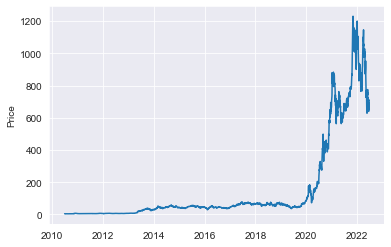

In [9]:
plt.plot(df.Close)
plt.ylabel('Price')
plt.show()

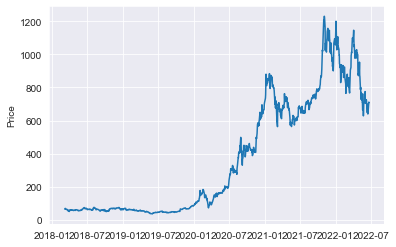

In [10]:
# In the last three years
plt.plot(df.iloc[-1080:].Close)
plt.ylabel('Price')
plt.show()

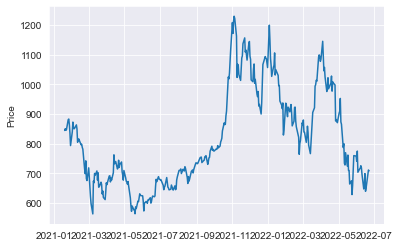

In [11]:
# This year
plt.plot(df.iloc[-360:].Close)
plt.ylabel('Price')
plt.show()

### Creating Labels for Cobalt, Nickel and Lithium

In [12]:
df['Cobalt'] = df.Close * 3.5
df['Nickel'] = df.Close * 18.75
df['Lithium'] = df.Close * 2.75

In [13]:
df.head()

,Close,Volume,Cobalt,Nickel,Lithium
Date,,,,,
2010-06-29,4.778,93831500,16.723,89.5875,13.1395
2010-06-30,4.766,85935500,16.681,89.3625,13.1065
2010-07-01,4.392,41094000,15.372,82.3500,12.0780
2010-07-02,3.840,25699000,13.440,72.0000,10.5600
2010-07-06,3.222,34334500,11.277,60.4125,8.8605


In [14]:
df.tail()

,Close,Volume,Cobalt,Nickel,Lithium
Date,,,,,
2022-06-15,699.000000,39710600,2446.500000,13106.250000,1922.250000
2022-06-16,639.299988,35796900,2237.549958,11986.874775,1758.074967
2022-06-17,650.280029,30810900,2275.980102,12192.750544,1788.270080
2022-06-21,711.109985,40931000,2488.884948,13333.312219,1955.552459
2022-06-22,708.260010,33702500,2478.910035,13279.875187,1947.715027


### Predicting Tesla Stock

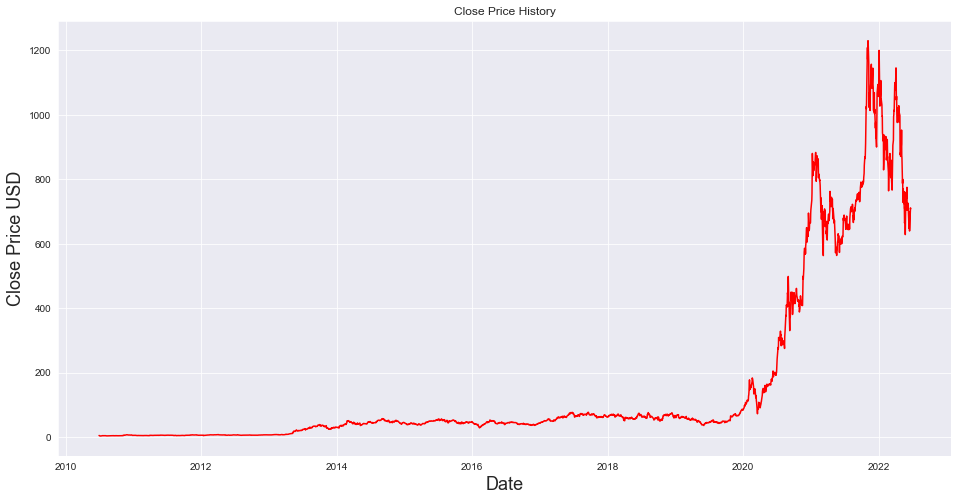

In [15]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.show()

In [16]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2414

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.52750765],
       [0.57709392],
       [0.57477073]])

In [18]:
# Train Data Split
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])

# Test Data Split
test_data= scaled_data[training_data_len-60:, :]

x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [19]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2354, 60, 1)

In [21]:
model =Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(1))

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
2354/2354 [==============================] - 46s 18ms/step - loss: 1.9984e-05
Epoch 2/10
2354/2354 [==============================] - 46s 20ms/step - loss: 1.0512e-05
Epoch 3/10
2354/2354 [==============================] - 51s 22ms/step - loss: 7.8865e-06
Epoch 4/10
2354/2354 [==============================] - 48s 20ms/step - loss: 6.1977e-06
Epoch 5/10
2354/2354 [==============================] - 52s 22ms/step - loss: 5.6361e-06
Epoch 6/10
2354/2354 [==============================] - 53s 22ms/step - loss: 4.4523e-06
Epoch 7/10
2354/2354 [==============================] - 56s 24ms/step - loss: 5.3194e-06
Epoch 8/10
2354/2354 [==============================] - 59s 25ms/step - loss: 4.4630e-06
Epoch 9/10
2354/2354 [==============================] - 55s 23ms/step - loss: 3.5993e-06
Epoch 10/10
2354/2354 [==============================] - 59s 25ms/step - loss: 3.3714e-06


In [23]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(603, 60, 1)

In [24]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 14ms/step


In [25]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6.9100084881039106

C:\Users\leo-d\AppData\Local\Temp\ipykernel_19516\288518054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


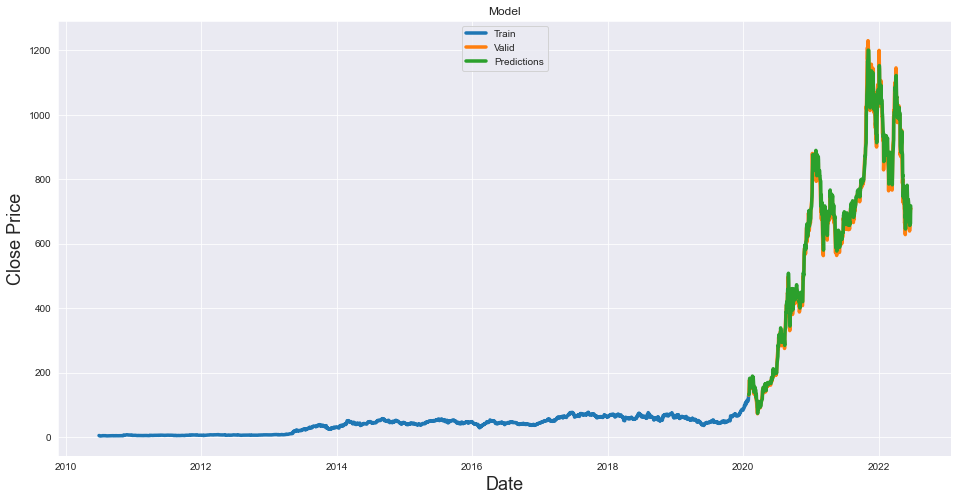

In [27]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(train['Close'],linewidth=3.5)
plt.plot(valid[['Close','Predictions']],linewidth=3.5)
plt.legend(['Train','Valid','Predictions'], loc='upper center')

In [29]:
valid['Predictions']

Date
2020-01-31    131.960022
2020-02-03    133.510559
2020-02-04    161.103424
2020-02-05    182.384354
2020-02-06    150.292801
                 ...    
2022-06-15    676.308472
2022-06-16    708.639648
2022-06-17    656.458008
2022-06-21    663.389038
2022-06-22    717.439819
Name: Predictions, Length: 603, dtype: float32

In [30]:
valid.head()

,Close,Predictions
Date,,
2020-01-31,130.113998,131.960022
2020-02-03,156.000000,133.510559
2020-02-04,177.412003,161.103424
2020-02-05,146.940002,182.384354
2020-02-06,149.792007,150.292801


In [32]:
results = pd.DataFrame()

results['Prediction'] = valid['Predictions']

results['Cobalt'] = results.Prediction * 3.5
results['Nickel'] = results.Prediction * 18.75
results['Lithium'] = results.Prediction * 2.75

In [33]:
results.head()

,Prediction,Cobalt,Nickel,Lithium
Date,,,,
2020-01-31,131.960022,461.860077,2474.250488,362.890076
2020-02-03,133.510559,467.286957,2503.322998,367.154053
2020-02-04,161.103424,563.862000,3020.689209,443.034424
2020-02-05,182.384354,638.345215,3419.706543,501.556976
2020-02-06,150.292801,526.024780,2817.989990,413.305206
